## 大綱
 WEEK6
1. 套件說明
2. 資料前處理
    - 2.1 基本資料介紹
    - 2.2 資料清理
    - 2.3 文章斷詞與整理
3. 找出重要詞彙 - 以TFIDF為例
    - 3.1 應用於資料集（套件）
    - 3.2 檢視結果
4.  透過結巴斷詞與N-gram幫助建立斷詞字典
    - 4.1 Bigram
    - 4.2 Trigram
    - 4.3 更新斷詞字典
    - 4.4 Bigram視覺化
5.  Pairwise correlation
    - 5.1 找出相關性高的詞彙
    - 5.2 畫出關係圖
6. 計算文章相似度

WEEK7

1. 如何將以數字向量代表一篇文章？
        * `CountVectorizer`
        * `TfidfVectorizer`
2. 基本的分類模型流程，包含以下三步驟：
    * 前處理 (preprocess)
    * 建模 (train model)
    * 評估與預測 (evaluation and predict)
3. cross validation
4. 不同分類器的效果
5. 可解釋的可視化模型結果
6. 預測其他家新聞文章的版別

## 2.資料前處理

### 2.1 資料介紹
資料來源:工作流程管理--聯合新聞版

版面:股市&產經

搜尋關鍵字:AI、人工智慧

排除字::AIT、Alphabet、All、Air

日期區間:24/01~24/03

文章總比數:5520；比例:5:6

In [ ]:
#載入套件
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import re
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np

import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
#匯入資料
df = pd.read_excel('./raw_data/AI_NEWS_2401_2403.xlsx')
df.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,https://udn.com/news/story/7239/7676612,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,NaN,UDN
1,2,華碩1月4日尾牙 將釋展望,2023-12-31 01:33:00,產經,https://udn.com/news/story/7240/7676437,PC品牌大廠華碩（2357）實體尾牙睽違三年後，即將於明年1月4日登場，華碩將找來情歌天后梁...,NaN,UDN
2,3,三星旗艦機來了 台鏈吃補,2023-12-31 05:20:00,產經,https://udn.com/news/story/7240/7676644,三星據傳將於美國時間1月17日於加州聖荷西發表全新旗艦機Galaxy S24，為非蘋陣營20...,NaN,UDN


### 2.2 資料處理
後續在共現相關性圖中發現有一個樹全部都是廣告文，於是返回資料清理將其去除。

In [ ]:
def remove_ad_from_text(text, markers):
    if not isinstance(text, str):
        # 如果 text 不是字符串，直接返回原始值
        return text

    for marker in markers:
        index = text.find(marker)
        if index != -1:
            return text[:index]
    return text

# 假設您的 DataFrame 是 df，並且有一個名為 'artContent' 的欄位
# 首先，創建一個標誌列表
markers = ["。?", "。？",'。 ? ','。?']

df['cleaned_artContent'] = df['artUrl'].apply(lambda x: remove_ad_from_text(x, markers))


### 2.2.1 資料處理
將欄位名稱做調整並刪去無用欄位

In [ ]:
MetaData = df.copy()

# 刪除 'artSecondCatagory' 和 'artContent' 欄位
MetaData = MetaData.drop(['artSecondCatagory', 'artContent','dataSource','artUrl'], axis=1)

# 將 'artUrl' 欄位重命名為 'artContent'
MetaData = MetaData.rename(columns={'cleaned_artContent': 'artContent'})
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,system_id,artTitle,artDate,artCatagory,artContent,sentence
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...
1,2,華碩1月4日尾牙 將釋展望,2023-12-31 01:33:00,產經,PC品牌大廠華碩（2357）實體尾牙睽違三年後，即將於明年1月4日登場，華碩將找來情歌天后梁...,品牌大廠華碩實體尾牙睽違三年後即將於明年月日登場華碩將找來情歌天后梁靜茹超人氣樂團告五人及女...
2,3,三星旗艦機來了 台鏈吃補,2023-12-31 05:20:00,產經,三星據傳將於美國時間1月17日於加州聖荷西發表全新旗艦機Galaxy S24，為非蘋陣營20...,三星據傳將於美國時間月日於加州聖荷西發表全新旗艦機為非蘋陣營年首發旗艦機備受關注預料軟硬體規...


In [ ]:
# 下載下來確認結果
df.to_excel("check_clean.xlsx", index=False, engine='openpyxl')

###  2.3 文章斷詞與整理

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [ ]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

Building prefix dict from d:\PYTHON\碩士生\social_media\study group2\dict\dict.txt.big ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.u4c52e3d73c78c038add02de1c89ff034.cache
Loading model cost 0.966 seconds.
Prefix dict has been built successfully.


,system_id,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,經濟日報
1,2,華碩1月4日尾牙 將釋展望,2023-12-31 01:33:00,產經,PC品牌大廠華碩（2357）實體尾牙睽違三年後，即將於明年1月4日登場，華碩將找來情歌天后梁...,品牌大廠華碩實體尾牙睽違三年後即將於明年月日登場華碩將找來情歌天后梁靜茹超人氣樂團告五人及女...,提供
2,3,三星旗艦機來了 台鏈吃補,2023-12-31 05:20:00,產經,三星據傳將於美國時間1月17日於加州聖荷西發表全新旗艦機Galaxy S24，為非蘋陣營20...,三星據傳將於美國時間月日於加州聖荷西發表全新旗艦機為非蘋陣營年首發旗艦機備受關注預料軟硬體規...,經濟日報


## 3.找出重要詞彙 - 以TFIDF為例

TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
- **TF** (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率  
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數  
- **IDF** (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log  
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 )

### 3.1 計算TF-IDF示範（套件）

In [ ]:
ai_df = MetaData.copy()
ai_df.head(3)

,system_id,artTitle,artDate,artCatagory,artContent,sentence
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...
1,2,華碩1月4日尾牙 將釋展望,2023-12-31 01:33:00,產經,PC品牌大廠華碩（2357）實體尾牙睽違三年後，即將於明年1月4日登場，華碩將找來情歌天后梁...,品牌大廠華碩實體尾牙睽違三年後即將於明年月日登場華碩將找來情歌天后梁靜茹超人氣樂團告五人及女...
2,3,三星旗艦機來了 台鏈吃補,2023-12-31 05:20:00,產經,三星據傳將於美國時間1月17日於加州聖荷西發表全新旗艦機Galaxy S24，為非蘋陣營20...,三星據傳將於美國時間月日於加州聖荷西發表全新旗艦機為非蘋陣營年首發旗艦機備受關注預料軟硬體規...


In [ ]:
# 保留需要的欄位
ai_df = ai_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
ai_df['word'] = ai_df.sentence.apply(getToken).map(' '.join)

ai_df.head()

,system_id,sentence,word
0,1,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,經濟日報 提供 經濟日報 台股 擂台 上周五 結算 第季 比賽 成果 期股 大富翁 翁士峻 ...
1,2,品牌大廠華碩實體尾牙睽違三年後即將於明年月日登場華碩將找來情歌天后梁靜茹超人氣樂團告五人及女...,品牌 大廠 華碩 實體 尾牙 睽違 三年 登場 華碩 找來 情歌 天后 梁靜茹 超人氣 樂團...
2,3,三星據傳將於美國時間月日於加州聖荷西發表全新旗艦機為非蘋陣營年首發旗艦機備受關注預料軟硬體規...,三星 據傳 將於 美國 時間 加州 聖荷西 發表 全新 旗艦機 非蘋 陣營 首發 旗艦機 備...
3,4,猿猴我的老天啊這是隸屬於的圖片託管服務在年月自動生成的標註但標註的是歲黑人男子威廉的黑白肖像...,猿猴 老天 這是 隸屬於 圖片 託管 服務 自動 生成 標註 標註 黑人 男子 威廉 黑白 ...
4,5,每到一年年底就有來自各路人馬的經濟學家及分析師們開始為來年的全球經濟或金融市場把個脈做個預測...,每到 一年 年底 各路人馬 經濟學家 分析師 來年 全球 經濟 金融市場 預測 媒體 引述 ...


#### 詞頻統計

In [ ]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(ai_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一七,一三,一三兆,一三六八,一三減,一上,一上場,一下子,一不小心,...,龐大,龐德,龐雜,龔明鑫,龔明鑫並,龔明鑫則,龔明鑫將,龔明鑫還,龜山,龜速
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5516,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5518,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 詞頻計算

In [ ]:
transformer = TfidfTransformer()
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一一,一七,一三,一三兆,一三六八,一三減,一上,一上場,一下子,一不小心,...,龐大,龐德,龐雜,龔明鑫,龔明鑫並,龔明鑫則,龔明鑫將,龔明鑫還,龜山,龜速
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2 檢視結果   
根據tfidf值來挑出重要詞彙的方法有許多種，以下舉兩個方法當範例：
- 取每一個字詞在所有文件裡的TF-IDF平均值
- 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [ ]:
ai_tfidf = TFIDF_df.mean().to_frame().reset_index()
ai_tfidf.columns = ["word", "avg"]

ai_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
24243,成長,0.025227
6471,億元,0.024853
20854,市場,0.024683
4643,伺服器,0.024059
35661,營收,0.022049
12619,台股,0.020851
37096,產業,0.020280
12469,台灣,0.020250
10911,半導體,0.019139
11451,去年,0.018317


#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [ ]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一七,一三,一三兆,一三六八,一三減,一上,一上場,一下子,...,龐大,龐德,龐雜,龔明鑫,龔明鑫並,龔明鑫則,龔明鑫將,龔明鑫還,龜山,龜速
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,5516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5516,5517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5517,5518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5518,5519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
322345915,5516,龜速,0.0
322345916,5517,龜速,0.0
322345917,5518,龜速,0.0
322345918,5519,龜速,0.0


nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [ ]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)

    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
1196,伺服器,339
3315,台股,295
1668,億元,257
9443,營收,219
6705,指數,205
3278,台灣,199
2878,半導體,187
7659,晶片,179
7679,智慧,175
6597,投資,170


## 4.透過結巴斷詞與N-gram幫助建立斷詞字典
N-gram 指文本中連續出現的n個語詞。   
透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。   

N-gram範例：

### 4.1 Bigram

In [ ]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]

    return seg_list

In [ ]:
ai_bigram = MetaData.copy()

ai_bigram["word"] = ai_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
ai_bigram = ai_bigram.explode('word')

ai_bigram.head(3)

,system_id,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,經濟日報 提供
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,提供 經濟日報
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,經濟日報 台股


#### 統計最常出現的bigram組合

In [ ]:
# 計算每個組合出現的次數
ai_bigram_count = ai_bigram['word'].value_counts().reset_index()
ai_bigram_count.head()
ai_bigram_count.sort_values('word', ascending=False).head(10)

,index,word
0,營收 億元,1086
1,歷史 新高,678
2,去年 第季,645
3,成長 動能,624
4,半導體 產業,580
5,合併 營收,574
6,先進 封裝,561
7,中國 大陸,538
8,資料 中心,525
9,每股 純益,475


找到許多應該合併的詞，例如歷史新高、成長動能等等。並加入到字典中

### 4.2 Trigram

In [ ]:
ai_trigram = MetaData.copy()

ai_trigram["word"] = ai_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
ai_trigram = ai_trigram.explode('word')

ai_trigram.head(3)

,system_id,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,經濟日報 提供 經濟日報
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,提供 經濟日報 台股
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,經濟日報 台股 擂台


#### 統計最常出現的trigram組合

In [ ]:
# 計算每個組合出現的次數
ai_trigram_count = ai_trigram['word'].value_counts().reset_index()

ai_trigram_count.sort_values('word', ascending=False).head(10)

,index,word
0,合併 營收 億元,418
1,稅後 純益 億元,230
2,創下 歷史 新高,166
3,去年 營收 億元,156
4,投信 台股 團隊,147
5,安聯 投信 台股,146
6,營收 億元 年增,140
7,費城 半導體 指數,138
8,地緣 政治 風險,138
9,配發 現金 股利,135


找到許多應該合併的詞，例如費城半導體指數、歷史新高、稅後純益等等。並加入到字典中

### 4.3 使用自建字典

In [ ]:
# 新增ai相關自定義字典
jieba.load_userdict('./dict/ai_lexicon.txt')

**使用自建辭典進行斷詞與計算**

In [ ]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,經濟日報
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,提供
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,經濟日報


### 4.4 Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [ ]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,經濟日報 提供
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,提供 經濟日報
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,經濟日報 台股


In [ ]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('營收', '億元'), 650),
 (('去年', '第季'), 645),
 (('合併營收', '億元'), 508),
 (('先進', '製程'), 460),
 (('市場', '預期'), 441)]

In [ ]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [ ]:
# Create network plot
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率

# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

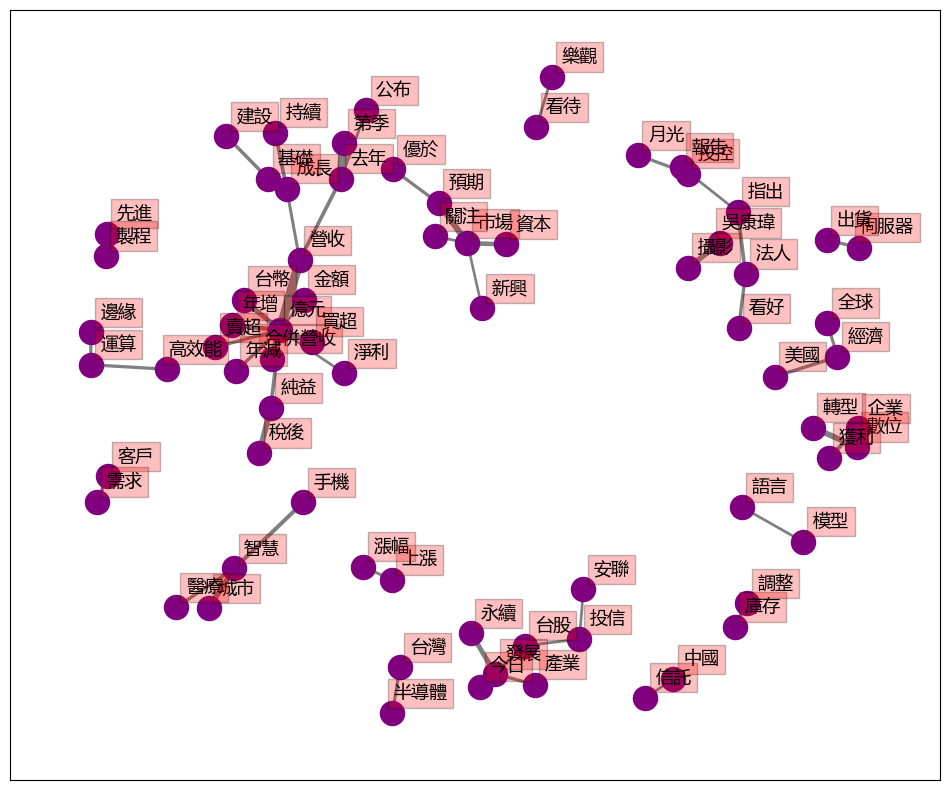

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# 設置 matplotlib 使用的字型
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 例如設置為 Microsoft YaHei 字型
plt.rcParams['axes.unicode_minus'] = False  # 解決負號「-」顯示為方塊的問題

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.show()

左手邊的主題主要在討論公司的財報表現與發展方向；其他則有智慧城市、數位轉型、法人投信等主題

## 5.Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

In [ ]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,經濟日報 提供 經濟日報 台股 擂台 上周五 結算 第季 比賽 成果 期股 大富翁 翁士峻 ...
1,2,華碩1月4日尾牙 將釋展望,2023-12-31 01:33:00,產經,PC品牌大廠華碩（2357）實體尾牙睽違三年後，即將於明年1月4日登場，華碩將找來情歌天后梁...,品牌大廠華碩實體尾牙睽違三年後即將於明年月日登場華碩將找來情歌天后梁靜茹超人氣樂團告五人及女...,品牌 大廠 華碩 實體 尾牙 睽違 三年 登場 華碩 找來 情歌 天后 梁靜茹 超人氣 樂團...
2,3,三星旗艦機來了 台鏈吃補,2023-12-31 05:20:00,產經,三星據傳將於美國時間1月17日於加州聖荷西發表全新旗艦機Galaxy S24，為非蘋陣營20...,三星據傳將於美國時間月日於加州聖荷西發表全新旗艦機為非蘋陣營年首發旗艦機備受關注預料軟硬體規...,三星 據傳 將於 美國 時間 加州 聖荷西 發表 全新 旗艦機 非蘋 陣營 首發 旗艦機 備...


In [ ]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一年,上市,上漲,下半年,下跌,世界,中國,中心,主題,也將,...,預期,預計,領域,題材,顯示,風險,體驗,高達,高階,鴻海
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,3,0,2,0,3,3,18,0,0,3,...,3,1,0,0,1,8,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,3
5516,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5518,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一年,上市,上漲,下半年,下跌,世界,中國,中心,主題,...,預期,預計,領域,題材,顯示,風險,體驗,高達,高階,鴻海
0,一年,1.000000,0.011886,0.018851,0.014587,-0.021291,0.021575,0.029059,0.022719,0.043134,...,0.031536,0.030174,-0.014235,0.017786,0.043736,0.086914,-0.038736,0.066408,-0.027890,-0.025876
1,上市,0.011886,1.000000,-0.001551,-0.001736,0.012716,0.019003,0.003578,0.023082,0.011887,...,-0.028539,0.025109,-0.023029,0.025690,-0.010875,0.053891,0.010559,0.031789,-0.022537,-0.011155
2,上漲,0.018851,-0.001551,1.000000,-0.052865,0.286560,-0.020743,0.022692,-0.064838,-0.022985,...,0.144039,-0.035038,-0.100845,0.176517,0.057955,0.027704,-0.069692,0.053484,-0.061739,0.009818
3,下半年,0.014587,-0.001736,-0.052865,1.000000,-0.026562,-0.052281,0.037456,-0.026474,-0.039906,...,0.176865,0.143417,-0.005702,-0.030730,-0.023427,-0.031004,-0.061636,-0.021971,0.085399,-0.010546
4,下跌,-0.021291,0.012716,0.286560,-0.026562,1.000000,-0.018634,0.021937,-0.041264,-0.030084,...,0.058518,-0.029430,-0.072888,0.110042,0.032962,0.026952,-0.044625,0.017755,-0.043249,-0.003263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,風險,0.086914,0.053891,0.027704,-0.031004,0.026952,0.030434,0.081309,0.002643,0.077239,...,0.058663,-0.045292,-0.002925,0.049318,0.145435,1.000000,-0.010749,0.011574,-0.041508,-0.024784
296,體驗,-0.038736,0.010559,-0.069692,-0.061636,-0.044625,0.050642,-0.017519,0.020892,0.077121,...,-0.089209,-0.007891,0.112644,-0.045135,0.094667,-0.010749,1.000000,-0.006886,-0.008624,-0.006567
297,高達,0.066408,0.031789,0.053484,-0.021971,0.017755,0.018338,0.007401,0.010578,-0.013589,...,-0.003903,0.012510,-0.013213,0.064622,0.060407,0.011574,-0.006886,1.000000,0.004372,-0.001092
298,高階,-0.027890,-0.022537,-0.061739,0.085399,-0.043249,-0.017557,0.116012,0.049886,-0.025451,...,0.083990,0.026959,0.053995,-0.016270,-0.010475,-0.041508,-0.008624,0.004372,1.000000,-0.023091


In [ ]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
16699,積電,台積電,0.637761
59755,台積電,積電,0.637761
45372,城市,智慧,0.633935
21751,智慧,城市,0.633935
74478,外資,買超,0.611662
23648,買超,外資,0.611662
16554,台積,台積電,0.600360
16255,台積電,台積,0.600360
69928,先進,製程,0.534444
8633,製程,先進,0.534444


### 5.1 和 「客戶」, 「智慧」 相關性最高的 10 個詞彙

In [ ]:
ice_sum = word_cor_df[(word_cor_df["word1"] == "客戶")].sort_values(by = ['cor'], ascending = False).head(10)
taste_sum = word_cor_df[(word_cor_df["word1"] == "智慧")].sort_values(by = ['cor'], ascending = False).head(10)

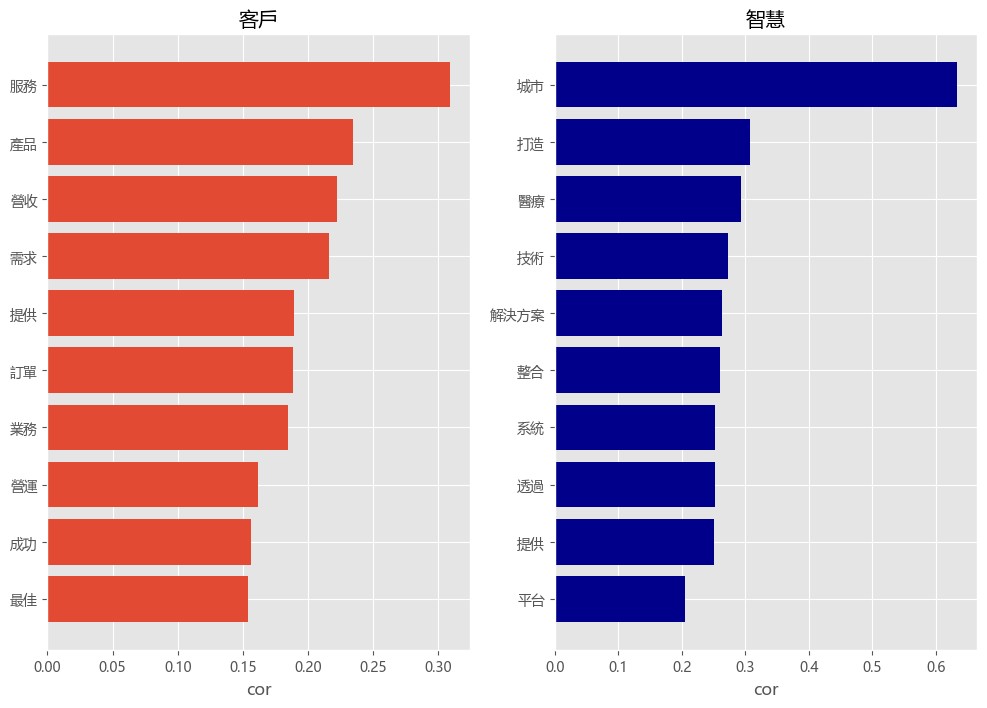

In [ ]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('客戶')
plt.xlabel('cor')
plt.barh(ice_sum['word2'],ice_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('智慧')
plt.xlabel('cor')
plt.barh(taste_sum['word2'],taste_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

發現現在客戶著重的點不只在產品，服務相關也有很大的討論；
智慧方面被提到做多的則是智慧城市

### 5.2 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

In [ ]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [ ]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,台股,上漲,0.305367
1,指數,上漲,0.399777
2,營收,去年,0.361474
3,第季,去年,0.339323
4,國際,台灣,0.301738
5,上漲,台股,0.305367
6,指數,台股,0.391249
7,台灣,國際,0.301738
8,服務,客戶,0.309060
9,投資人,市場,0.339721


In [ ]:
# Create network plot
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])

# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

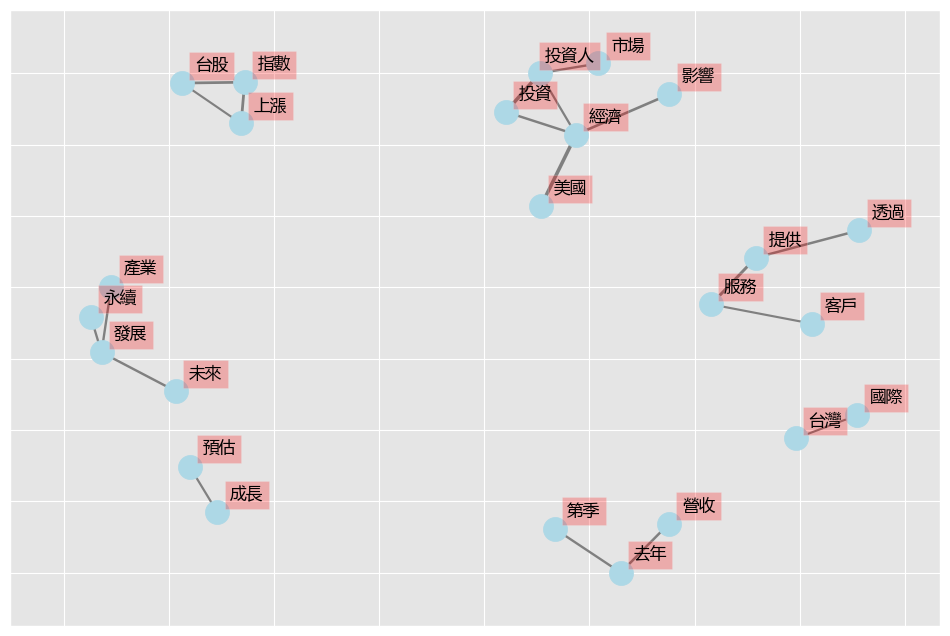

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)

plt.show()

## 6.計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章   


In [ ]:
data_cos = data_cor.copy()
data_cos.head(3)

,system_id,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍,2023-12-31 00:59:00,產經,圖／經濟日報提供經濟日報台股擂台上周五（29日）結算第4季比賽成果，「期股大富翁」翁士峻以...,圖經濟日報提供經濟日報台股擂台上周五日結算第季比賽成果期股大富翁翁士峻以的單季報酬蟬聯季冠軍...,經濟日報 提供 經濟日報 台股 擂台 上周五 結算 第季 比賽 成果 期股 大富翁 翁士峻 ...
1,2,華碩1月4日尾牙 將釋展望,2023-12-31 01:33:00,產經,PC品牌大廠華碩（2357）實體尾牙睽違三年後，即將於明年1月4日登場，華碩將找來情歌天后梁...,品牌大廠華碩實體尾牙睽違三年後即將於明年月日登場華碩將找來情歌天后梁靜茹超人氣樂團告五人及女...,品牌 大廠 華碩 實體 尾牙 睽違 三年 登場 華碩 找來 情歌 天后 梁靜茹 超人氣 樂團...
2,3,三星旗艦機來了 台鏈吃補,2023-12-31 05:20:00,產經,三星據傳將於美國時間1月17日於加州聖荷西發表全新旗艦機Galaxy S24，為非蘋陣營20...,三星據傳將於美國時間月日於加州聖荷西發表全新旗艦機為非蘋陣營年首發旗艦機備受關注預料軟硬體規...,三星 據傳 將於 美國 時間 加州 聖荷西 發表 全新 旗艦機 非蘋 陣營 首發 旗艦機 備...


In [ ]:
transformer = TfidfTransformer()
print(transformer)
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一年,上市,上漲,下半年,下跌,世界,中國,中心,主題,也將,...,預期,預計,領域,題材,顯示,風險,體驗,高達,高階,鴻海
0,0.000000,0.000000,0.121814,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.436004,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.194355,0.081014,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.216920,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.155635,0.000000,0.000000,0.000000,0.225915,0.000000,0.0,0.000000
4,0.041474,0.000000,0.023013,0.000000,0.044894,0.044204,0.274305,0.0,0.0,0.041251,...,0.025784,0.011025,0.000000,0.000000,0.011948,0.098392,0.000000,0.028403,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.119785,0.000000,0.000000,0.000000,0.133629,0.000000,0.000000,0.0,0.569611
5516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.119799,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.096685,0.000000,0.000000,0.0,0.000000
5517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068149,0.000000,0.0,0.000000


計算文章間的cosine similarity

In [ ]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視與第一篇文章相似的文章

In [ ]:
cos_df = pd.DataFrame(cosine_matrix[0], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,1.000000
1,0.002617
2,0.034717
3,0.095867
4,0.076371
...,...
5515,0.073750
5516,0.030148
5517,0.040180
5518,0.020659


In [ ]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle
0,1.000000,Q4台股擂台 翁士峻賺45% 蟬聯季冠軍
4281,0.583087,Q1台股擂台 張貽程賺37%
3691,0.512348,"創下紅盤日第三高！台股金龍年開紅盤收18,644點、大漲548點"
3630,0.511528,是否抱股過年 掌握「三四五」訣竅
1396,0.470149,台積電看好AI前景 法人：台股短線止穩、季線有撐
3578,0.459706,龍年關注聯準會降息議題與AI題材 台股表現可期
3647,0.458643,展望台股龍年 法人看好AI、半導體拉貨題材
3644,0.457839,這檔狂漲10倍居冠！台股兔年「飆股排行榜」出爐 19檔個股漲幅超過3倍
3279,0.452089,2024台股交易首日 市場聚焦3題材、4大代工成交量稱霸
3576,0.448683,龍年關注聯準會降息議題與AI題材 永豐期貨春節期間海外交易不打烊


相關性最高的文章也都是跟第1篇一樣是在討論台股，且是樂觀的。

檢視與第14篇文章相似的文章

In [ ]:
cos_df_14 = pd.DataFrame(cosine_matrix[14], columns=['cos_similarity'])

cos_df_14 = cos_df_14.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df_14.loc[:,["cos_similarity", "artTitle"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle
14,1.000000,通膨頑固 債券多元收益靠精選策略掌握
17,0.934650,聯準會利率連五凍後的投資策略
767,0.889753,抱得住 平台母子基金正報酬機率高達95%
220,0.864366,野村台股基金閃金光，定期定額科技基金長線享AI甜頭！
152,0.820379,勞工退休金全靠這一檔！勞動基金三成重押台積電
283,0.820158,勞動基金1月賺763億 表現優於大盤
1034,0.797002,鉅亨買基金「超底王」新上市！自動捕捉急跌加碼機會
3032,0.795158,2024第2季基金投資趨勢／錢進越南基金 掌握機會財
948,0.793856,2024第2季基金投資趨勢／新興市場債、多重資產 各押三成
925,0.791582,第27屆傑出基金金鑽獎「國內基金獎」 野村投信抱三大獎成最大贏家


第14篇是在討論保守型投資的債券，最相關的也都是相對股票低風險的投資標的，相關的投資策略